# Ноутбук 2: Metric learning на EMNIST - SupCon и Proxy losses

**Цель:** Обучить эмбеддинги, устойчивые при большом числе классов, и сравнить с супервизорным бейзлайном.

**Что делаем:**
1. Загрузка данных из baseline ноутбука
2. M-per-class батч-семплинг для metric learning
3. Supervised Contrastive (SupCon) loss
4. Proxy-based losses (ProxyNCA/ProxyAnchor)
5. Обучение в разных режимах (чистый metric learning и совместно с CE)
6. Оценка и сравнение с baseline


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: NVIDIA L40


## 1. Загрузка данных из baseline ноутбука

Загружаем предобработанные данные и модель из первого ноутбука для использования в качестве отправной точки.


In [2]:
checkpoint_dir = Path("./checkpoints/baseline")

if not checkpoint_dir.exists():
    raise FileNotFoundError("Baseline checkpoint не найден. Запустите сначала ноутбук 01_baseline.ipynb (baseline)")

data_dir = checkpoint_dir / "data"
X_train = np.load(data_dir / "X_train_scaled.npy")
X_val = np.load(data_dir / "X_val_scaled.npy")
X_test = np.load(data_dir / "X_test_scaled.npy")
y_train = np.load(data_dir / "y_train.npy")
y_val = np.load(data_dir / "y_val.npy")
y_test = np.load(data_dir / "y_test.npy")

with open(data_dir / "scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

checkpoint = torch.load(checkpoint_dir / "best_model.pt", map_location='cpu')

print(f"Данные загружены:")
print(f"  Train: {len(X_train):,}")
print(f"  Val: {len(X_val):,}")
print(f"  Test: {len(X_test):,}")
print(f"  Классов: {len(np.unique(y_train))}")
print(f"  Input dim: {X_train.shape[1]}")


Данные загружены:
  Train: 628,138
  Val: 69,794
  Test: 116,323
  Классов: 62
  Input dim: 784


## 2. M-per-class батч-семплинг

Для metric learning критично иметь сбалансированные батчи, где каждый класс представлен одинаковым количеством примеров. Реализуем m-per-class семплинг: каждый батч содержит m примеров из каждого класса.

Формула размера батча: $B = C \times m$, где $C$ - количество классов, $m$ - примеров на класс.


In [3]:
class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MPerClassSampler(Sampler):
    def __init__(self, y, m_per_class=4, shuffle=True):
        self.y = np.array(y)
        self.m_per_class = m_per_class
        self.shuffle = shuffle
        
        unique_classes = np.unique(self.y)
        self.class_indices = {cls: np.where(self.y == cls)[0] for cls in unique_classes}
        self.n_classes = len(unique_classes)
        self.length = self.n_classes * self.m_per_class
        
    def __iter__(self):
        indices = []
        for cls in self.class_indices:
            cls_indices = self.class_indices[cls]
            if len(cls_indices) >= self.m_per_class:
                selected = np.random.choice(cls_indices, self.m_per_class, replace=False)
            else:
                selected = np.random.choice(cls_indices, self.m_per_class, replace=True)
            indices.extend(selected.tolist())
        
        if self.shuffle:
            np.random.shuffle(indices)
        
        return iter(indices)
    
    def __len__(self):
        return self.length


train_dataset = EMNISTDataset(X_train, y_train)
val_dataset = EMNISTDataset(X_val, y_val)
test_dataset = EMNISTDataset(X_test, y_test)

m_per_class = 4
sampler = MPerClassSampler(y_train, m_per_class=m_per_class)
batch_size = len(sampler)

train_loader_metric = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

# Отдельный train_loader для оценки (использует все данные, как в baseline)
train_loader_eval = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"M-per-class семплинг настроен:")
print(f"  m_per_class: {m_per_class}")
print(f"  Batch size: {batch_size}")
print(f"  Train batches (metric): {len(train_loader_metric)}")
print(f"  Train batches (eval): {len(train_loader_eval)}")


M-per-class семплинг настроен:
  m_per_class: 4
  Batch size: 248
  Train batches (metric): 1
  Train batches (eval): 1227


## 3. Модель с проектором для metric learning

Используем тот же MLP-энкодер из baseline, но добавляем проектор для metric learning losses. Проектор преобразует эмбеддинги в пространство для вычисления контрастного лосса.

Архитектура: $x \rightarrow \text{encoder}(x) \rightarrow e \rightarrow \text{projector}(e) \rightarrow z$, где $z$ - проекция для SupCon, $e$ - финальные эмбеддинги.


In [4]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.3, embedding_dim=128):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, embedding_dim))
        self.encoder = nn.Sequential(*layers)
        
    def forward(self, x, normalize=True):
        embeddings = self.encoder(x)
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings


class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.BatchNorm1d(projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )
    
    def forward(self, embeddings, normalize=True):
        projections = self.projection(embeddings)
        if normalize:
            projections = F.normalize(projections, p=2, dim=1)
        return projections


class ClassificationHead(nn.Module):
    def __init__(self, embedding_dim, n_classes):
        super().__init__()
        self.classifier = nn.Linear(embedding_dim, n_classes)
    
    def forward(self, embeddings):
        return self.classifier(embeddings)


class MetricLearningModel(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dims=[512, 256, 128], 
                 dropout=0.3, embedding_dim=128, projection_dim=128):
        super().__init__()
        self.encoder = MLPEncoder(input_dim, hidden_dims, dropout, embedding_dim)
        self.projector = ProjectionHead(embedding_dim, projection_dim)
        self.classifier = ClassificationHead(embedding_dim, n_classes)
    
    def forward(self, x, return_projection=False, return_embeddings=False):
        embeddings = self.encoder(x, normalize=True)
        projection = self.projector(embeddings, normalize=True)
        logits = self.classifier(embeddings)
        
        result = {'logits': logits}
        if return_projection:
            result['projection'] = projection
        if return_embeddings:
            result['embeddings'] = embeddings
        return result
    
    def get_embeddings(self, x):
        with torch.no_grad():
            return self.encoder(x, normalize=True)


n_classes = len(np.unique(y_train))
input_dim = X_train.shape[1]
embedding_dim = 128
projection_dim = 128

model = MetricLearningModel(
    input_dim=input_dim,
    n_classes=n_classes,
    hidden_dims=[512, 256, 128],
    dropout=0.3,
    embedding_dim=embedding_dim,
    projection_dim=projection_dim
).to(device)

print(f"Модель создана:")
print(f"  Input dim: {input_dim}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Projection dim: {projection_dim}")
print(f"  Num classes: {n_classes}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Модель создана:
  Input dim: 784
  Embedding dim: 128
  Projection dim: 128
  Num classes: 62
  Total parameters: 625,726


## 4. Supervised Contrastive Loss (SupCon)

Supervised Contrastive Loss минимизирует расстояние между примерами одного класса и максимизирует расстояние между примерами разных классов.

Формула SupCon:

$$\mathcal{L}_{SupCon} = -\frac{1}{N} \sum_{i=1}^{N} \frac{1}{|P(i)|} \sum_{p \in P(i)} \log \frac{\exp(z_i \cdot z_p / \tau)}{\sum_{a \in A(i)} \exp(z_i \cdot z_a / \tau)}$$

где:
- $P(i)$ - множество позитивов (примеры того же класса, что и $i$)
- $A(i)$ - множество всех примеров в батче кроме $i$
- $\tau$ - температура
- $z_i$ - L2-нормированная проекция примера $i$

Применяем легкие аугментации: feature dropout и Gaussian noise.


In [5]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, projections, labels):
        device = projections.device
        batch_size = projections.shape[0]
        
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float().to(device)
        
        contrast_feature = projections
        anchor_feature = projections
        
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )
        
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        exp_logits = torch.exp(logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)
        
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        
        loss = -mean_log_prob_pos.mean()
        
        return loss


def apply_augmentations(x, feature_dropout=0.1, noise_std=0.01):
    if feature_dropout > 0:
        dropout_mask = torch.rand_like(x) > feature_dropout
        x = x * dropout_mask.float()
    
    if noise_std > 0:
        noise = torch.randn_like(x) * noise_std
        x = x + noise
    
    return x


print("SupCon Loss и аугментации созданы")


SupCon Loss и аугментации созданы


## 5. Proxy-based Loss (ProxyAnchor)

ProxyAnchor использует прокси-векторы для каждого класса, что делает обучение более устойчивым при большом количестве классов.

Формула ProxyAnchor:

$$\mathcal{L}_{ProxyAnchor} = \frac{1}{|C^+|}\sum_{c \in C^+} \log(1 + \sum_{x \in X_c^+} \exp(-\alpha(s(x, p_c) - \delta))) + \frac{1}{|C|}\sum_{c \in C} \log(1 + \sum_{x \in X_c^-} \exp(\alpha(s(x, p_c) + \delta)))$$

где:
- $p_c$ - прокси для класса $c$
- $X_c^+$ - примеры класса $c$ (позитивы)
- $X_c^-$ - примеры не класса $c$ (негативы)
- $s(x, p)$ - скалярное произведение (косинусное сходство для L2-нормированных векторов)
- $\alpha$ - масштабирующий параметр
- $\delta$ - маржа


In [6]:
class ProxyAnchorLoss(nn.Module):
    def __init__(self, n_classes, embedding_dim, alpha=32, delta=0.1):
        super().__init__()
        self.n_classes = n_classes
        self.alpha = alpha
        self.delta = delta
        
        self.proxies = nn.Parameter(torch.randn(n_classes, embedding_dim))
        nn.init.kaiming_normal_(self.proxies, mode='fan_out')
    
    def forward(self, embeddings, labels):
        proxies = F.normalize(self.proxies, p=2, dim=1)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        sim_matrix = torch.matmul(embeddings, proxies.T)
        
        pos_mask = torch.zeros_like(sim_matrix)
        for i, label in enumerate(labels):
            pos_mask[i, label] = 1
        
        neg_mask = 1 - pos_mask
        
        pos_exp = torch.exp(-self.alpha * (sim_matrix - self.delta)) * pos_mask
        neg_exp = torch.exp(self.alpha * (sim_matrix + self.delta)) * neg_mask
        
        pos_term = torch.log(1 + pos_exp.sum(dim=1)).mean()
        neg_term = torch.log(1 + neg_exp.sum(dim=0)).mean()
        
        loss = pos_term + neg_term
        
        return loss


print("ProxyAnchor Loss создан")


ProxyAnchor Loss создан


## 6. Функции для оценки эмбеддингов

Используем семплирование для ускорения оценки kNN, как в baseline ноутбуке.


In [7]:
def evaluate_embeddings_knn(train_embeddings, train_labels, 
                            query_embeddings, query_labels, k=5):
    nn_model = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
    nn_model.fit(train_embeddings)
    
    distances, indices = nn_model.kneighbors(query_embeddings)
    
    recall_k = []
    for i in range(len(query_labels)):
        neighbor_labels = train_labels[indices[i]]
        recall_k.append(1.0 if query_labels[i] in neighbor_labels else 0.0)
    
    recall_at_k_score = np.mean(recall_k)
    
    return {
        'recall@k': recall_at_k_score,
        'distances': distances,
        'indices': indices
    }


def evaluate_model_embeddings(model, dataloader, device, sample_size=0.2):
    """
    Извлекает эмбеддинги из модели с опциональным семплированием.
    Оптимизировано: семплирует батчи ДО извлечения эмбеддингов для ускорения.
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    
    # Если нужен семплинг, вычисляем сколько батчей нужно обработать
    total_batches = len(dataloader)
    if sample_size < 1.0:
        # Обрабатываем только часть батчей для ускорения
        n_batches_to_process = max(1, int(total_batches * sample_size))
        # Выбираем равномерно распределенные батчи
        batch_indices = np.linspace(0, total_batches - 1, n_batches_to_process, dtype=int)
        batch_set = set(batch_indices)
    else:
        batch_set = None  # Обрабатываем все батчи
    
    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(tqdm(dataloader, desc="Extracting embeddings")):
            # Пропускаем батчи, если нужен семплинг
            if batch_set is not None and batch_idx not in batch_set:
                continue
                
            X_batch = X_batch.to(device)
            embeddings = model.get_embeddings(X_batch)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    if len(all_embeddings) == 0:
        return np.array([]), np.array([])
    
    all_embeddings = np.concatenate(all_embeddings)
    all_labels = np.concatenate(all_labels)
    
    # Дополнительное семплирование внутри батчей, если нужно более точное семплирование
    if sample_size < 1.0 and len(all_embeddings) > 0:
        # Вычисляем точное количество примеров для семплирования
        target_size = int(len(dataloader.dataset) * sample_size)
        if len(all_embeddings) > target_size:
            np.random.seed(42)
            indices = np.random.choice(len(all_embeddings), size=target_size, replace=False)
            all_embeddings = all_embeddings[indices]
            all_labels = all_labels[indices]
    
    return all_embeddings, all_labels


def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return {'accuracy': accuracy, 'macro_f1': macro_f1}


print("Функции для оценки созданы")


Функции для оценки созданы


## 7. Обучение: чистый SupCon

Обучаем модель только с SupCon loss для получения качественных эмбеддингов без явной классификационной задачи. Метрики (Recall@k) будем вычислять только в конце для сравнения подходов.


In [8]:
model_supcon = MetricLearningModel(
    input_dim=input_dim,
    n_classes=n_classes,
    hidden_dims=[512, 256, 128],
    dropout=0.3,
    embedding_dim=embedding_dim,
    projection_dim=projection_dim
).to(device)

supcon_loss = SupConLoss(temperature=0.07)
optimizer = torch.optim.AdamW(model_supcon.parameters(), lr=1e-3, weight_decay=1e-4)

history_supcon = {
    'train_loss': []
}

num_epochs = 20

print(f"Обучение с чистым SupCon loss на {num_epochs} эпох...")


Обучение с чистым SupCon loss на 20 эпох...


In [9]:
for epoch in range(num_epochs):
    model_supcon.train()
    train_loss = 0.0
    
    for X_batch, y_batch in tqdm(train_loader_metric, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        X_batch_aug = apply_augmentations(X_batch, feature_dropout=0.1, noise_std=0.01)
        
        optimizer.zero_grad()
        output = model_supcon(X_batch_aug, return_projection=True)
        projections = output['projection']
        
        loss = supcon_loss(projections, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader_metric)
    history_supcon['train_loss'].append(train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print()


Epoch 1/20: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1/20:
  Train Loss: 7.3017



Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 2/20:
  Train Loss: 6.4308



Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch 3/20:
  Train Loss: 5.6885



Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 4/20:
  Train Loss: 5.1014



Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 5/20:
  Train Loss: 4.8875



Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 6/20:
  Train Loss: 4.7748



Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 7/20:
  Train Loss: 4.6607



Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 8/20:
  Train Loss: 4.6034



Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 9/20:
  Train Loss: 4.6412



Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 10/20:
  Train Loss: 4.6440



Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch 11/20:
  Train Loss: 4.6547



Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 12/20:
  Train Loss: 4.6352



Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 13/20:
  Train Loss: 4.6382



Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 14/20:
  Train Loss: 4.6657



Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch 15/20:
  Train Loss: 4.6147



Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 16/20:
  Train Loss: 4.6551



Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch 17/20:
  Train Loss: 4.6217



Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 18/20:
  Train Loss: 4.5923



Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch 19/20:
  Train Loss: 4.5137



Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

Epoch 20/20:
  Train Loss: 4.6363



## 8. Обучение: CE + SupCon (совместное обучение)

Комбинируем Cross-Entropy loss для классификации с SupCon loss для улучшения эмбеддингов:

$$\mathcal{L} = \mathcal{L}_{CE} + \lambda \cdot \mathcal{L}_{SupCon}$$

где $\lambda$ - коэффициент балансировки. Метрики (Recall@k) будем вычислять только в конце для сравнения подходов.


In [10]:
model_combined = MetricLearningModel(
    input_dim=input_dim,
    n_classes=n_classes,
    hidden_dims=[512, 256, 128],
    dropout=0.3,
    embedding_dim=embedding_dim,
    projection_dim=projection_dim
).to(device)

ce_loss = nn.CrossEntropyLoss()
supcon_loss_combined = SupConLoss(temperature=0.07)
lambda_supcon = 0.5

optimizer_combined = torch.optim.AdamW(model_combined.parameters(), lr=1e-3, weight_decay=1e-4)

history_combined = {
    'train_loss': [],
    'train_ce_loss': [],
    'train_supcon_loss': []
}

print(f"Обучение с CE + SupCon (λ={lambda_supcon}) на {num_epochs} эпох...")


Обучение с CE + SupCon (λ=0.5) на 20 эпох...


In [11]:
for epoch in range(num_epochs):
    model_combined.train()
    train_loss = 0.0
    train_ce = 0.0
    train_supcon = 0.0
    
    for X_batch, y_batch in tqdm(train_loader_metric, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        X_batch_aug = apply_augmentations(X_batch, feature_dropout=0.1, noise_std=0.01)
        
        optimizer_combined.zero_grad()
        output = model_combined(X_batch_aug, return_projection=True)
        
        logits = output['logits']
        projections = output['projection']
        
        loss_ce = ce_loss(logits, y_batch)
        loss_supcon = supcon_loss_combined(projections, y_batch)
        loss = loss_ce + lambda_supcon * loss_supcon
        
        loss.backward()
        optimizer_combined.step()
        
        train_loss += loss.item()
        train_ce += loss_ce.item()
        train_supcon += loss_supcon.item()
    
    train_loss /= len(train_loader_metric)
    train_ce /= len(train_loader_metric)
    train_supcon /= len(train_loader_metric)
    
    history_combined['train_loss'].append(train_loss)
    history_combined['train_ce_loss'].append(train_ce)
    history_combined['train_supcon_loss'].append(train_supcon)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f} (CE: {train_ce:.4f}, SupCon: {train_supcon:.4f})")
    print()


Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 1/20:
  Train Loss: 7.4175 (CE: 4.1273, SupCon: 6.5803)



Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch 2/20:
  Train Loss: 7.0471 (CE: 4.1258, SupCon: 5.8426)



Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 3/20:
  Train Loss: 6.7605 (CE: 4.1274, SupCon: 5.2663)



Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 4/20:
  Train Loss: 6.5750 (CE: 4.1270, SupCon: 4.8961)



Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 5/20:
  Train Loss: 6.5057 (CE: 4.1222, SupCon: 4.7670)



Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 6/20:
  Train Loss: 6.5059 (CE: 4.1214, SupCon: 4.7690)



Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 7/20:
  Train Loss: 6.4532 (CE: 4.1258, SupCon: 4.6547)



Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 8/20:
  Train Loss: 6.4601 (CE: 4.1198, SupCon: 4.6806)



Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 9/20:
  Train Loss: 6.4693 (CE: 4.1175, SupCon: 4.7035)



Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 10/20:
  Train Loss: 6.4498 (CE: 4.1155, SupCon: 4.6686)



Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 11/20:
  Train Loss: 6.4739 (CE: 4.1146, SupCon: 4.7185)



Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 12/20:
  Train Loss: 6.4680 (CE: 4.1171, SupCon: 4.7018)



Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 13/20:
  Train Loss: 6.4149 (CE: 4.1073, SupCon: 4.6153)



Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 14/20:
  Train Loss: 6.4473 (CE: 4.1028, SupCon: 4.6890)



Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 15/20:
  Train Loss: 6.3909 (CE: 4.1024, SupCon: 4.5769)



Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 16/20:
  Train Loss: 6.4052 (CE: 4.1025, SupCon: 4.6054)



Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 17/20:
  Train Loss: 6.4011 (CE: 4.0955, SupCon: 4.6113)



Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 18/20:
  Train Loss: 6.3920 (CE: 4.0963, SupCon: 4.5914)



Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 19/20:
  Train Loss: 6.3544 (CE: 4.0936, SupCon: 4.5215)



Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

Epoch 20/20:
  Train Loss: 6.3776 (CE: 4.0911, SupCon: 4.5730)



## 9. Сравнение результатов

Сравниваем результаты всех подходов на тестовом наборе: baseline (только CE), чистый SupCon, и CE+SupCon. Здесь вычисляем метрики Recall@k через kNN на эмбеддингах для финального сравнения.


In [12]:
print("Оценка на тестовом наборе...")
print("="*60)

models_to_evaluate = [
    ("Baseline (CE only)", None),
    ("SupCon only", model_supcon),
    ("CE + SupCon", model_combined)
]

results = {}

for name, model_eval in models_to_evaluate:
    if model_eval is None:
        print(f"\n{name}: используем результаты из baseline ноутбука")
        continue
    
    print(f"\n{name}:")
    # Используем train_loader_eval для оценки (полный dataset, как в baseline)
    train_emb, train_lbl = evaluate_model_embeddings(model_eval, train_loader_eval, device, sample_size=0.1)
    test_emb, test_lbl = evaluate_model_embeddings(model_eval, test_loader, device, sample_size=0.2)
    
    test_knn_5 = evaluate_embeddings_knn(train_emb, train_lbl, test_emb, test_lbl, k=5)
    test_knn_10 = evaluate_embeddings_knn(train_emb, train_lbl, test_emb, test_lbl, k=10)
    test_knn_20 = evaluate_embeddings_knn(train_emb, train_lbl, test_emb, test_lbl, k=20)
    
    results[name] = {
        'recall@5': test_knn_5['recall@k'],
        'recall@10': test_knn_10['recall@k'],
        'recall@20': test_knn_20['recall@k']
    }
    
    print(f"  Test Recall@5: {test_knn_5['recall@k']:.4f}")
    print(f"  Test Recall@10: {test_knn_10['recall@k']:.4f}")
    print(f"  Test Recall@20: {test_knn_20['recall@k']:.4f}")

print("\n" + "="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ:")
print("="*60)
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Recall@5: {metrics['recall@5']:.4f}")
    print(f"  Recall@10: {metrics['recall@10']:.4f}")
    print(f"  Recall@20: {metrics['recall@20']:.4f}")


Оценка на тестовом наборе...

Baseline (CE only): используем результаты из baseline ноутбука

SupCon only:


Extracting embeddings: 100%|██████████| 228/228 [00:00<00:00, 316.38it/s]
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


  Test Recall@5: 0.8456
  Test Recall@10: 0.8937
  Test Recall@20: 0.9296

CE + SupCon:


Extracting embeddings: 100%|██████████| 228/228 [00:00<00:00, 275.21it/s]


  Test Recall@5: 0.8482
  Test Recall@10: 0.8991
  Test Recall@20: 0.9337

ИТОГОВОЕ СРАВНЕНИЕ:

SupCon only:
  Recall@5: 0.8456
  Recall@10: 0.8937
  Recall@20: 0.9296

CE + SupCon:
  Recall@5: 0.8482
  Recall@10: 0.8991
  Recall@20: 0.9337


## 10. Визуализация истории обучения

Визуализируем динамику обучения для разных подходов.


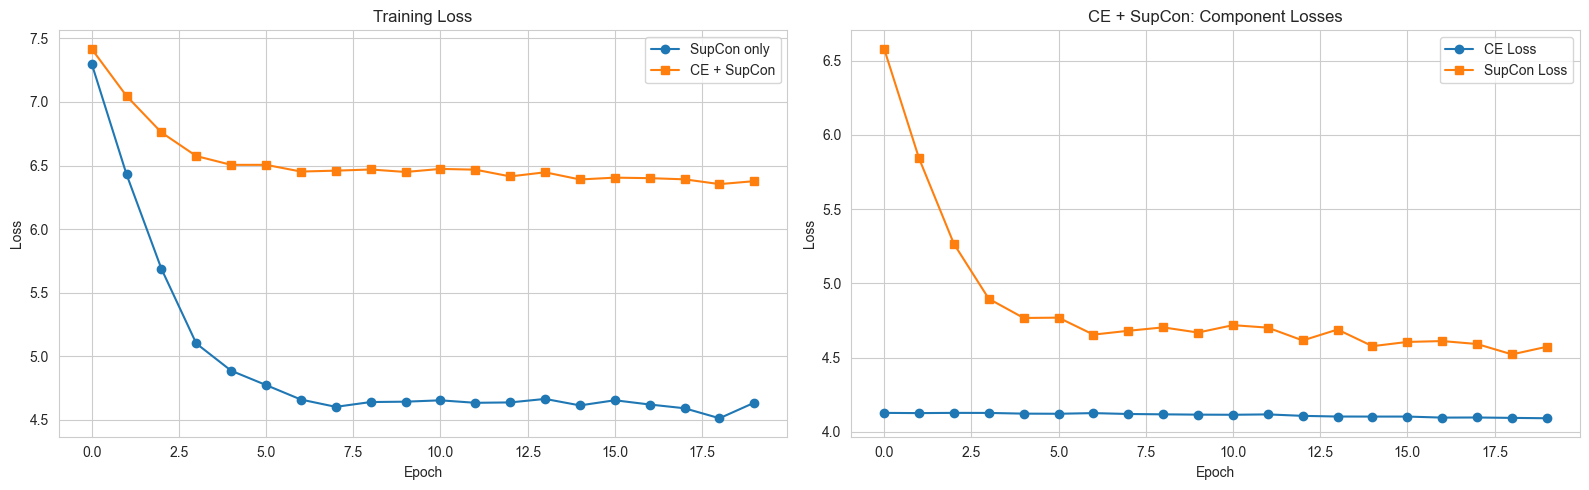

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history_supcon['train_loss'], label='SupCon only', marker='o')
axes[0].plot(history_combined['train_loss'], label='CE + SupCon', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_combined['train_ce_loss'], label='CE Loss', marker='o')
axes[1].plot(history_combined['train_supcon_loss'], label='SupCon Loss', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('CE + SupCon: Component Losses')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 11. Сохранение результатов

Сохраняем обученные модели для использования в следующих ноутбуках.


In [14]:
save_dir = Path("./checkpoints/metric_learning")
save_dir.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model_supcon.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'n_classes': n_classes,
        'embedding_dim': embedding_dim,
        'projection_dim': projection_dim,
        'hidden_dims': [512, 256, 128],
        'dropout': 0.3
    },
    'history': history_supcon
}, save_dir / "supcon_model.pt")

torch.save({
    'model_state_dict': model_combined.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'n_classes': n_classes,
        'embedding_dim': embedding_dim,
        'projection_dim': projection_dim,
        'hidden_dims': [512, 256, 128],
        'dropout': 0.3
    },
    'history': history_combined,
    'lambda_supcon': lambda_supcon
}, save_dir / "combined_model.pt")

with open(save_dir / "results.pkl", "wb") as f:
    pickle.dump(results, f)

print(f"Модели сохранены в {save_dir}")


Модели сохранены в checkpoints/metric_learning
